# Chapter 1: Single cell simulation with current injection (for Project S4)

In this example we will build a network consisting of a single biophysically detailed cell. Then we will run a short simulation with a current injection at the soma of the cell, then look at the output of spikes, membrane potential and calcium flux.


**Note** - This example is adapted from the __[BMTK Tutorial 01](https://github.com/AllenInstitute/bmtk/blob/develop/docs/tutorial/01_single_cell_clamped.ipynb)__.

**requirements:**
* Python 2.7, 3.6+
* bmtk
* NEURON 7.4+

## 1. Building the network

First step is to use the bmtk Network Builder to create and save the network. First we instantiate a network with a name or our choosing (since throughout this tutorial we will use cell models that from the mouse cortex, let's call our network 'mcortex'). 

Once we have a network, we can add a single node by calling the add_nodes method.

In [2]:
from bmtk.builder.networks import NetworkBuilder

net = NetworkBuilder('Nr5a1-Cre')
net.add_nodes(cell_name='386049446',
              potental='exc',
              model_type='biophysical',
              model_template='ctdb:Biophys1.hoc',
              model_processing='aibs_perisomatic',
              dynamics_params='386049446_fit.json',
              morphology='Nr5a1-Cre_Ai14-177334.05.01.01_491459171_m.swc')

Some of the parameters used to create the node are optional and only for our benefit. Others are necessary for when we will eventually run a simulation:
* *cell_name* (optional) - Name/type of cell we will be modeling.
* *potential* (optional) - Use to indicate that it is an excitatory type cell.
* *model_type* - Used by the simulator to indicate that we are using a biophysical cell.
* __*dynamics_params*__ - Model parameters. File will be downloaded from the Allen Cell Types Database. 
* __*morphology*__ - Model morphology. File will be downloaded from the Allen Cell Types Database.
* *model_processing* - A custom function used by the simulator to load the model into NEURON using Allen Cell-Types files for perisomatic models ('aibs_allactive' for all_active model).
 
#### Building and saving
The final thing to do is to build and save the network. If successful, we should see a combination of hdf5 and csv files in the './network' directory, these files are used describe the network, and can be saved, stored and run at a later date.

First, it's a good idea to remove any old files in the "network" folder so they don't interfere with the current simulation.

In [3]:
%%bash
rm network/*

If you get the output:

rm: cannot remove 'network/*': No such file or directory

It's OK. Keep going.

In [4]:
net.build()
net.save_nodes(output_dir='network')

Use the NetworkBuilder nodes() method to show that a node of our parameters was created

In [5]:
for node in net.nodes():
    print(node)

{'cell_name': '386049446', 'potental': 'exc', 'model_type': 'biophysical', 'model_template': 'ctdb:Biophys1.hoc', 'model_processing': 'aibs_perisomatic', 'dynamics_params': '386049446_fit.json', 'morphology': 'Nr5a1-Cre_Ai14-177334.05.01.01_491459171_m.swc', 'node_type_id': 100, 'node_id': 0}


## 2. Setting up the simulator enviornment

Now that the network has been built, we can use the BioNet simulator to setup and run it using NEURON. The easiest ways to do this is to copy and modify [existing simulation setup](https://github.com/AllenInstitute/bmtk/tree/develop/docs/examples/bio_14cells), or use the  ```bmtk.utils.sim_setup``` script which can be called from the command-line

```bash
$ python -m bmtk.utils.sim_setup  --report-vars v,cai --network network --iclamp 0.18,500.0,1000.0 --dt 0.025 --tstop 2000.0 --include-examples --compile-mechanisms bionet Proj_S5
```
Or call the function directly in python

In [6]:
from bmtk.utils.sim_setup import build_env_bionet

build_env_bionet(base_dir='Proj_S5',      # Where to save the scripts and config files 
                 network_dir='network',    # Location of directory containing network files
                 tstop=2000.0, dt=0.025,     # Run a simulation for 2000 ms at 0.025 ms intervals
                 report_vars=['v', 'cai'], # Tells simulator we want to record membrane potential and calcium traces
                 current_clamp={           # Creates a step current from 500.ms to 1500.0 ms  
                     'amp': 0.180,
                     'delay': 500.0,
                     'duration': 1000.0
                 },
                 include_examples=True,    # Copies components files
                 compile_mechanisms=True   # Will try to compile NEURON mechanisms
                )

ERROR:bmtk.utils.sim_setup:  Was unable to compile mechanism in D:\BMTK\ProjectS5\Proj_S5\components\mechanisms


<div class="alert alert-warning">
**Warning**: You may see an error that it filed while trying to compile the NEURON mechanisms - especially if jupyter is unable to find your NEURON environment path. If this happens you will need to manually compile the mechanisms:  

```
 cd Proj_S5/components/mechanisms  
 nrnivmodl modfiles
```
</div>



This will create the directory **Proj_S5** (feel free to give it a better name or set it to a different locations) with a number of new files and folders. Some of the more important ones include:
* **circuit_config.json** - A configuration file that contains the location of the network files we created above. Plus location of neuron and synpatic models, templates, morphologies and mechanisms required to build our instantiate individual cell models.


* **simulation_config.json** - contains information about the simulation. Including initial conditions and run-time configuration (_run_ and _conditions_). In the _inputs_ section we define what external sources we will use to drive the network (in this case a current clamp). And in the _reports_ section we define the variables (soma membrane potential and calcium) that will be recorded during the simulation 


* **components/biophysical_neuron_models/472363762_fit.json** - The parameter file for the cell we're modeling. Originally [downloaded from the Allen Cell Types Database](http://celltypes.brain-map.org/neuronal_model/download/482934212)


* **components/biophysical_neuron_models/Scnn1a_473845048_m.swc** - The morphology file for our cell. Originally [downloaded from the Allen Cell Types Database](http://celltypes.brain-map.org/neuronal_model/download/482934212)


Modifying these files with a text editor, or swapping out different parameter or morphologies, allows changing the simulation without extra programming.

### Place the model files in proper directory
We will need to move the parameters and morphology files we will be using in the model into our simulator enviornment by doing either
* Copy *386049446_fit.json*  and place it in ./Proj_S5/components/biophysical_neuron_models
* Copy *Nr5a1-Cre_Ai14-177334.05.01.01_491459171_m.swc* and place it in ./Proj_S5/components/morphologies

or directly run the command below in python.

In [1]:
%%bash
cp source/386049446_fit.json Proj_S5/components/biophysical_neuron_models
cp source/Nr5a1-Cre_Ai14-177334.05.01.01_491459171_m.swc Proj_S5/components/morphologies

## 3. Running the simulation

Once our config file is setup we can run a simulation either through the command line:
```bash
$ python run_bionet.py simulation_config.json
```

or through the script

In [2]:
from bmtk.simulator import bionet

conf = bionet.Config.from_json('Proj_S5/simulation_config.json')
conf.build_env()
net = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=net)
sim.run()

2020-04-20 13:56:12,657 [INFO] Created log file
2020-04-20 13:56:12,776 [INFO] Building cells.
2020-04-20 13:56:12,930 [INFO] Building recurrent connections
2020-04-20 13:56:12,961 [INFO] Running simulation for 2000.000 ms with the time step 0.025 ms
2020-04-20 13:56:12,968 [INFO] Starting timestep: 0 at t_sim: 0.000 ms
2020-04-20 13:56:12,971 [INFO] Block save every 5000 steps
2020-04-20 13:56:13,283 [INFO]     step:5000 t_sim:125.00 ms
2020-04-20 13:56:13,573 [INFO]     step:10000 t_sim:250.00 ms
2020-04-20 13:56:13,877 [INFO]     step:15000 t_sim:375.00 ms
2020-04-20 13:56:14,181 [INFO]     step:20000 t_sim:500.00 ms
2020-04-20 13:56:14,498 [INFO]     step:25000 t_sim:625.00 ms
2020-04-20 13:56:14,818 [INFO]     step:30000 t_sim:750.00 ms
2020-04-20 13:56:15,207 [INFO]     step:35000 t_sim:875.00 ms
2020-04-20 13:56:15,499 [INFO]     step:40000 t_sim:1000.00 ms
2020-04-20 13:56:15,795 [INFO]     step:45000 t_sim:1125.00 ms
2020-04-20 13:56:16,114 [INFO]     step:50000 t_sim:1250.00 

<div class="alert alert-warning">
**Warning**: If you the the following error
    argument not a density mechanism name.
You will need to compile the NEURON mechanisms  


```
 cd Proj_S5/components/mechanisms
 nrnivmodl modfiles
 
```
</div>

A quick breakdown of the script:
```python
conf = config.from_json('config.json')
io.setup_output_dir(conf)
nrn.load_neuron_modules(conf)
```
This section loads the configuration file, it setups the output directory and files for writing during the simulation, and loads NEURON mechanisms needed by the cell model(s) during the simulation.

```python
net = bionet.BioNetwork.from_config(conf)
```
Creates a NEURON representation of the network, including cell models that have been converted into their NEURON equivelents.

```python
sim = Simulation.from_config(conf, network=net)
sim.run()
```
Sets up and runs the NEURON simulation. When finished the output - spike times, membrane potential and Calcium influx, will be saved into the output directory as specified in the config.



## 4. Analyzing the run

The results of the simulation are placed into various files as specified in the "output" section of the config file. We can change this before run-time if required.

All simulations will save the spike times of the network cells. These are saved in csv format (output/spikes.txt) or hdf5 format(output/spikes.h5). To get the table of spike times for our single-cell network we can run the following method from the analyzer (gid 0 corresponds to our single cell).

In [2]:
from bmtk.analyzer.spike_trains import to_dataframe
to_dataframe(config_file='Proj_S5/simulation_config.json')

,timestamps,population,node_ids
0,539.175,Nr5a1-Cre,0
1,564.675,Nr5a1-Cre,0
2,594.400,Nr5a1-Cre,0
3,623.025,Nr5a1-Cre,0
4,651.225,Nr5a1-Cre,0
5,679.275,Nr5a1-Cre,0
6,707.200,Nr5a1-Cre,0
7,735.100,Nr5a1-Cre,0
8,762.950,Nr5a1-Cre,0
9,790.775,Nr5a1-Cre,0


When setting up the enviornment and config file we specified cell_vars=['v', 'cai']. This indicates to the simulator to also record membrane potential and calcium diffusion (and we can also specify other variables as long as they are supported in NEURON).

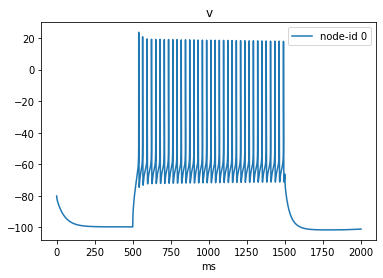

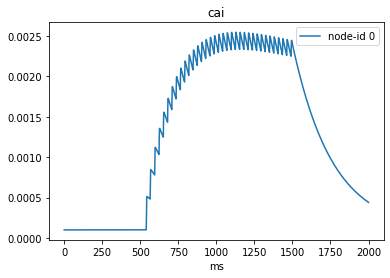

In [3]:
from bmtk.analyzer.cell_vars import plot_report

plot_report(config_file='Proj_S5/simulation_config.json')

Following script allows you to get recorded variables. You can further analyze the results if needed.

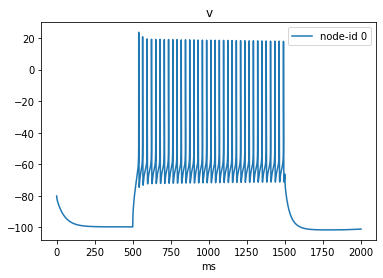

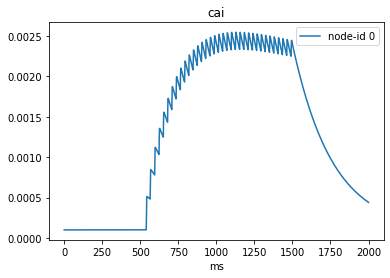

In [4]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

node_ids = [0] # cell ids to plot
output_dir = 'Proj_S5/output/' # output directory

def plot_var(var,node_ids,output_dir,net_name):
    f = h5py.File(output_dir+var+'_report.h5')
    t = np.arange(*f['report/'+net_name+'/mapping/time'])
    x = np.array(f['report/'+net_name+'/data'])
    plt.figure()
    plt.plot(t,x[:,node_ids])
    plt.legend(['node-id '+str(i) for i in node_ids])
    plt.xlabel('ms')
    plt.title(var)
    plt.show()

plot_var('v',node_ids,output_dir,'Nr5a1-Cre')
plot_var('cai',node_ids,output_dir,'Nr5a1-Cre')

In [ ]:
from bmtk.utils.cell_vars import CellVarsFile
from bmtk.analyzer.cell_vars import _get_cell_report

def get_variable_report(config_file=None, report_file=None, report_name=None, variable=None, gid=None):
    if report_file is None:
        report_name, report_file = _get_cell_report(config_file, report_name)
    var_report = CellVarsFile(report_file)
    time_steps = var_report.time_trace
    return var_report.data(gid=gid, var_name=variable), time_steps

Cai,t = get_variable_report(config_file='simulation_config.json', gid=0, variable="cai")
V,t = get_variable_report(config_file='simulation_config.json', gid=0, variable="v")

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure()
plt.subplot(2,1,1)
plt.plot(t,Cai)
plt.subplot(2,1,2)
plt.plot(t,V)
plt.show()

## 5. Additional Information

### Changing run-time parameters.
The input section lets us control stimulus onto the network. There are a number of different options which will be explained in the following tutorials. But even with a simple current injection we can adjust amplitude, delay and stimulation duration and measure the effect on the cell.
```json
"inputs": {
 	"current_clamp": {
      "input_type": "current_clamp",
      "module": "IClamp",
      "node_set": "all",
      "amp": 0.120,
      "delay": 500.0,
      "duration": 1000.0
    }
}
```

### Changing cell models
When building the network we defined the cell model and morphology through the 'dynamics_params' and 'morphology_file' options. After building and saving the network, these values were saved in the node-types csv file.

In [4]:
import pandas as pd
pd.read_csv('network/Nr5a1-Cre_node_types.csv', sep=' ')

,node_type_id,model_template,potental,model_type,cell_name,dynamics_params,model_processing,morphology
0,100,ctdb:Biophys1.hoc,exc,biophysical,386049446,386049446_fit.json,aibs_perisomatic,Nr5a1-Cre_Ai14-177334.05.01.01_491459171_m.swc


If we want to run the simulation on a different cell model, all we have to do is 
1. Download new parameters.json and morphology.swc into components/biophysical_neuron_models and components/morphologies respectively.
2. Open Nr5a1-Cre_node_types.csv in a text editor and update 'morphology_file' and 'params_file' accordingly.

In our simple one-cell example, it is likely faster to just rebuild the network. However the advantage of the use of the node types becomes clear once we start dealing with a larger network. For example we may have a network of hundreds of thousands of individual cells with tens of thousands of Scnn1a type cells. The process of adjusting/changing the Scnn1a parameter in the csv then starting another simulation only takes seconds, whereas rebuilding the entire network may take hours.